## 0. Import dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sys
sys.path.insert(0, '../utils')
from load_data import ames_housing
from preprocess_data import cat2int

import functools
import tensorflow as tf
from tensorflow.python.feature_column.feature_column import _LazyBuilder
tf.__version__

'1.9.0'

## 1. Load data

In [2]:
dirfolder = '../data/Ames-Housing'
numvalid = 100
train, valid, testdf, listnumeric, dictcategorical = ames_housing(dirfolder, numvalid)
traindf, trainy = train
validdf, validy = valid

Number of train samples is 1360.
Number of valid samples is 100.
Number of test samples is 1459.
Number of feature columns is 79.
Checking listnumeric ...
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
Checking dictcategorical ...
[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


/home/ymtoo/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/home/ymtoo/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## 2. Preprocess input data

In [3]:
traindata = cat2int(traindf, dictcategorical)
validdata = cat2int(validdf, dictcategorical)
testdata = cat2int(testdf, dictcategorical)

## 3. Create dataflow graphs

In [92]:
# hyperparameters
k = 0.9
learning_rate_0 = 1e-9
batch_size = 50
iterations = 1000000
monitor = 10000
threshold = 0.001

# network size
num_train, num_in = traindata.shape
num_out = 1

# create network graph
x = tf.placeholder(tf.float32, [None, num_in])
W = tf.Variable(tf.random_normal([num_in, num_out], stddev=0.1))
b = tf.Variable(tf.random_normal([num_out], stddev=0.1))
y = tf.matmul(x, W) + b

# create training graph
learning_rate = tf.placeholder(tf.float32)
y_ = tf.placeholder(tf.float32, [None, num_out])
cost = tf.losses.mean_squared_error(y_, y)
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

## 4. Training

In [94]:
# initialize
session = tf.Session()
session.run(tf.global_variables_initializer())

# train
start = 0
last_perf = 0
for i in range(iterations):
    session.run(train, feed_dict={x: traindata[start:start+batch_size, :], 
                                  y_: trainy[start:start+batch_size],
                                  learning_rate: learning_rate_0})
    start += batch_size
    if start > num_train-batch_size: 
        start = 0
    if i % monitor == 0:
        perf = session.run(cost, feed_dict={x: validdata, y_: validy})
        print("{}: {}".format(i, perf))
        if np.abs(perf-last_perf) < threshold:
            print("Difference between two consercutive costs is too small.")
            break
        last_perf = perf
        learning_rate_0 = learning_rate_0*k

predtrainy = session.run(y, feed_dict={x: traindata})
predvalidy = session.run(y, feed_dict={x: validdata})
predtesty = session.run(y, feed_dict={x: testdata})
session.close()

0: 22279755776.0
10000: 1420712064.0
20000: 1360902912.0
30000: 1329842944.0
40000: 1335279232.0
50000: 1316707328.0
60000: 1327590144.0
70000: 1324126592.0
80000: 1339389824.0
90000: 1322926464.0
100000: 1303852288.0
110000: 1306726016.0
120000: 1297871616.0
130000: 1299639936.0
140000: 1293108224.0
150000: 1301934592.0
160000: 1294612096.0
170000: 1293453696.0
180000: 1293930112.0
190000: 1289569792.0
200000: 1289855360.0
210000: 1290530560.0
220000: 1287413888.0
230000: 1288979456.0
240000: 1289125248.0
250000: 1287462144.0
260000: 1288288384.0
270000: 1285414144.0
280000: 1286178688.0
290000: 1286736128.0
300000: 1284957824.0
310000: 1285836544.0
320000: 1285905920.0
330000: 1285096960.0
340000: 1285486208.0
350000: 1284159744.0
360000: 1284914048.0
370000: 1284789504.0
380000: 1283937920.0
390000: 1284311040.0
400000: 1284457472.0
410000: 1284006528.0
420000: 1284340480.0
430000: 1283777664.0
440000: 1284017792.0
450000: 1284046464.0
460000: 1283705600.0
470000: 1283870208.0
48000

## 5. Plot results

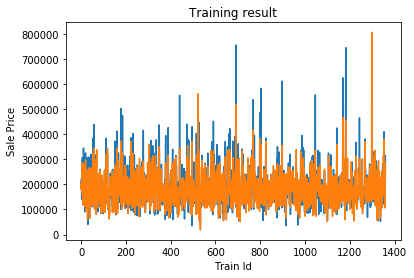

In [96]:
fig, ax = plt.subplots()
ax.plot(trainy, label='True')
ax.plot(predtrainy, label='Predict')
ax.set_xlabel('Train Id')
ax.set_ylabel('Sale Price')
ax.set_title('Training result');

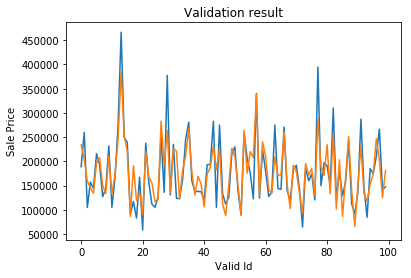

In [97]:
fig, ax = plt.subplots()
ax.plot(validy, label='True')
ax.plot(predvalidy, label='Predict')
ax.set_xlabel('Valid Id')
ax.set_ylabel('Sale Price')
ax.set_title('Validation result');

## 6. Save testing result for submission

In [84]:
sub_dict = {'Id': testdf.index.tolist(), 'SalePrice': predtesty.flatten()}
linreg_submission = pd.DataFrame(sub_dict)
linreg_submission.set_index('Id', inplace=True)
linreg_submission.to_csv('linreg_submission')